In [1]:
import numpy as np
import torch
import cv2
from dm_control import suite

import lib_duju.utils as duju_utils

from Model.ReplayBuffer import ReplayBuffer
from Model.ImageBuffer import ImageBuffer
from Model.SAC_base import target_initialize

from Model.triple_dqn import Triple_DQN
from Model.triple_dqn import train_triple_dqn

exp_title = "Conv_Discrete_TDQN_first"
print(exp_title)

train_print_flag = False
eval_print_flag = False

env = suite.load(domain_name="cartpole",task_name="swingup")

action_dim = 2

# state related variables
step_size = 3
channel_size = 1
height = 64
width = 96
skip_frame = 2

input_channel_size = step_size * channel_size

action_dict = { 0 : -1.0,
                1 : 1.0 }

reward_compensate = 1

print("reward_compensate", reward_compensate)
print("skip_frame", skip_frame)

lr = 3e-4
gamma = 0.99
device = torch.device("cuda")
max_episode = 10000
batch_size = 32
buffer_size = 5e5

replay_buffer = ReplayBuffer(buffer_size)
image_buffer = ImageBuffer(height, width, step_size, channel_size, int(buffer_size * 1.1))
eval_image_buffer = ImageBuffer(height, width, step_size, channel_size, 2000)

q_main = Triple_DQN(step_size, channel_size, height, width, action_dim, lr, device)
q_target = Triple_DQN(step_size, channel_size, height, width, action_dim, lr, device)

target_initialize(q_main, q_target)

print(q_main)

Conv_Discrete_TDQN_first
reward_compensate 1
skip_frame 2
input channel size :  3
fc input size :  1536
input channel size :  3
fc input size :  1536
Triple_DQN(
  (q1_conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (q1_conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (q1_conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (q1_fc1): Linear(in_features=1536, out_features=256, bias=True)
  (q1_fc2): Linear(in_features=256, out_features=2, bias=True)
  (q2_conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (q2_conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (q2_conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (q2_fc1): Linear(in_features=1536, out_features=256, bias=True)
  (q2_fc2): Linear(in_features=256, out_features=2, bias=True)
  (q3_conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (q3_conv2): Conv2d(32

In [2]:
duju_utils.torch_network_load(q_main,"trained/Conv_Discrete_TDQN_first_q_main_550.torch")

In [3]:
for epi_i in range(1, max_episode + 1):
    print(epi_i, end = "\t")

    timestep = env.reset()
    ep_reward = 0.0

    # timestep, reward, discount, observation
    end, _, _, _ = timestep
    end = end.last()

    frame = env.physics.render(camera_id=0, height = height, width =width)
    for _ in range(step_size):
        image_buffer.dm_add_gray(frame)
    s_idx = image_buffer.get_current_index()
    s_frame = image_buffer.get_state(s_idx)

    while not end:
        a_category = q_main.epsilon_sample(
                        torch.FloatTensor(s_frame).to(device).view(1, input_channel_size, height, width),
                        0.05
                )
        a_deploy = action_dict[a_category]

        for _ in range(skip_frame):
            timestep = env.step(a_deploy)

        end, r, _, _ = timestep
        end = end.last()
        frame = env.physics.render(camera_id=0, height=height, width=width)
        image_buffer.dm_add_gray(frame)

        s2_idx = image_buffer.get_current_index()
        s2_frame = image_buffer.get_state(s2_idx)

        replay_buffer.add(  np.array([s_idx]),
                          np.array([a_category]),
                          np.array([r * reward_compensate]),
                          np.array([end]),
                          np.array([s2_idx])    )

        # frame = env.physics.render(camera_id=0, height=480, width=640)  # [height, width, channel]

        if train_print_flag:
            cv2.imshow("train", cv2.resize(np.moveaxis(s2_frame,[0,1,2],[2,0,1]),(width*4,height*4)))
            cv2.waitKey(1)

        s_idx = s2_idx
        s_frame = s2_frame

        ep_reward += r * skip_frame

    for _idx in range(int(500 / skip_frame)):
        #print(_idx)
        max_q1, max_q2, max_q3, mean_reward = train_triple_dqn(q_main, q_target, replay_buffer, image_buffer, batch_size, gamma)

    print(int(ep_reward), "***", (float(max_q1), float(max_q2), float(max_q3), float(mean_reward)))

    #### Eval ####

    timestep = env.reset()
    eval_ep_reward = 0.0
    eval_action = []

    end, _, _, _ = timestep
    end = end.last()

    frame = env.physics.render(camera_id=0, height=height, width=width)
    for _ in range(step_size):
        eval_image_buffer.dm_add_gray(frame)
    s_idx = eval_image_buffer.get_current_index()
    s_frame = eval_image_buffer.get_state(s_idx)

    if (epi_i % 25) == 0 :
        while not end:
            a_category = q_main.epsilon_sample(
                        torch.FloatTensor(s_frame).to(device).view(1, input_channel_size, height, width),
                        0.0
                                                  )
            a_deploy = action_dict[a_category]
            eval_action.append(a_deploy)

            for _ in range(skip_frame):
                timestep = env.step(a_deploy)

            end, r, _, _ = timestep
            end = end.last()
            frame = env.physics.render(camera_id=0, height=height, width=width)
            eval_image_buffer.dm_add_gray(frame)

            s2_idx = eval_image_buffer.get_current_index()
            s2_frame = eval_image_buffer.get_state(s2_idx)

            s_idx = s2_idx
            s_frame = s2_frame

            eval_ep_reward += r * skip_frame

            # frame = env.physics.render(camera_id=0, height=480, width=640) #[height, width, channel]
            if eval_print_flag:
                cv2.imshow("eval", cv2.resize(np.moveaxis(s2_frame,[0,1,2],[2,0,1]),(width*8,height*8)))
                cv2.waitKey(1)


        print("Eval! *** ", eval_ep_reward)
        #print(eval_action)

    if (epi_i % 25) == 0:
        print("Networks Saved!")
        duju_utils.torch_network_save(q_main,"../trained/"+exp_title+"_q_main_"+str(epi_i)+".torch")
        duju_utils.torch_network_save(q_target, "../trained/"+exp_title+"_q_target_"+str(epi_i)+".torch")

cv2.destroyAllWindows()

1	144 *** (-10.55882740020752, -11.782700538635254, -8.288985252380371, 0.11882063746452332)
2	

KeyboardInterrupt: 

In [15]:
f = image_buffer.get_state(image_buffer.get_current_index())

In [17]:
import matplotlib.pyplot as plt

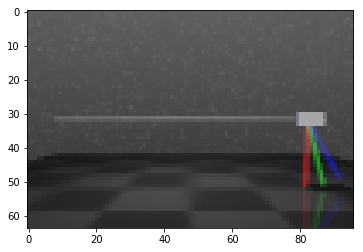

In [20]:
plt.imshow(np.moveaxis(f,[0,1,2],[2,0,1]))

In [24]:
c1 = q_main.q1_conv1(torch.FloatTensor(f).view([-1,3,64,96]).to(device))
cc1 = torch.relu(c1)

c2 = q_main.q1_conv2(cc1)
cc2 = torch.relu(c2)

c3 = q_main.q1_conv3(cc2)
cc3 = torch.relu(c3)

i0 = cc3.view([1,-1])

f1 = q_main.q1_fc1(i0)
ff1 = torch.relu(f1)

f2 = q_main.q1_fc2(ff1)

In [37]:
for i in i0.detach().cpu().numpy()[0]:
    print(i, end=", ")

0.11394328, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4136138, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39387375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3775158, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3734502, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14341074, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.6156707, 0.42581645, 0.55855083, 0.0, 0.0032163262, 0.024457991, 0.07059203, 0.14246593, 0.0, 0.058732137, 0.086389676, 0.0, 6.8720813, 3.9786782, 0.78339225, 0.21557204, 0.21559104, 0.0, 0.047208965, 0.0, 0.38238052, 0.084318385, 0.0783644, 0.0, 1.5610671, 0.0, 0.68041337, 0.7865776, 0.7977588, 0.7936969, 0.77598155, 0.7311852, 0.7223633, 0.74521613, 0.7776534, 0.76955956, 0.7385453, 0.5650129, 0.05334708, 0.53089994, 0.25164962, 0.31355762, 0.39318275, 0.26649234, 0.26397532, 0.32026356, 0.3375489, 0.34784272, 0.34097272, 0.034319326, 0.0, 0.6739679, 0.47807118, 0.4755587, 0.4615172, 0.50774807, 0.46

In [30]:
f1

tensor([[ -6.9884,  -6.6903,  -6.1592,  -9.2073,  -8.3062,  -5.2525,  -9.5563,
         -35.5211,   9.2574,  -3.2335,  -2.5600,  -4.3773,  -4.4034,  -9.0450,
         -26.0083,  -2.8001, -17.0871, -11.9424,  -4.8523, -10.6324, -20.3270,
          -5.5952,  -8.3332,  -3.8467,   6.4158,  -9.8118, -15.4842, -15.8885,
          -5.3106, -10.5861,  -7.7398, -11.2963,  -6.7310,  -6.0029,  -4.6876,
         -10.5564, -26.2895,  -4.9914,  -4.8675, -19.6386, -33.3371, -30.5157,
         -33.4973, -28.4299, -10.2745,  -3.2784, -18.7631,  -5.0383,  10.1023,
         -18.4750,   3.3397, -11.2331, -15.8266, -13.1094,  -5.4432, -13.2679,
         -18.9594, -21.7198,  -5.9816, -19.0302, -18.8994,  -4.7641,  -3.1982,
         -12.8597,  -8.3545,  -6.0375,  -2.5419, -12.0210,  -3.7569,  -5.9155,
          -7.3411, -27.2588,  -3.9971, -25.9953, -22.1309,  -5.7095,  -8.3597,
         -14.3174, -20.3755,  -6.1703,  -5.8600,  -7.5355,  -7.4667, -10.4496,
          -3.8395,  -4.6244,  -4.6330, -15.6728, -21

In [29]:
ff1

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          9.2574,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          6.4158,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         10.1023,  0.0000,  3.3397,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, 13.7163,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

In [28]:
f2

tensor([[-9.0490, -9.2739]], device='cuda:0', grad_fn=<AddmmBackward>)